# Поиск изображения по запросу

# Прекод

# Сборный проект-4

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

## Описание данных

Данные доступны по [ссылке](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

## Цель работы

Разработать демонстрационную версию поиска изображений по текстовому запросу. Модель должна:
- Получать векторные представления изображения и текста.
- Оценивать их соответствие через число от 0 до 1 (вероятность релевантности).

## План работы

**Исследовательский анализ данных**
- Агрегация экспертных оценок (например, голосование большинства).
- Объединение экспертных и краудсорсинговых оценок (возможно, с весовыми коэффициентами).
- Приведение целевой переменной к диапазону [0, 1].

**Проверка данных**

- Удаление изображений, нарушающих законодательство (например, с участием детей до 16 лет).

**Векторизация изображений**
- Использование предобученной CNN (например, ResNet-18) для извлечения признаков (исключая полносвязные слои).

**Векторизация текстов**
- Эксперименты с методами:
    - TF-IDF
    - Word2Vec
    - Трансформеры (например, BERT).

**Объединение векторов**
- Создание общего датасета с объединёнными векторами изображений, текстов и целевой переменной.

**Обучение модели предсказания соответствия**
- Разделение данных с учётом уникальности изображений (GroupShuffleSplit).
- Выбор модели (например, логистическая регрессия, градиентный бустинг или нейросеть).
- Определение метрики качества (например, ROC-AUC или кастомная метрика).

**Тестирование модели**
- Оценка качества на тестовой выборке.
- Проверка работы на данных из test_queries.csv и test_images.

## Ожидаемый результат

- Модель, предсказывающая вероятность соответствия текста и изображения (0–1).
- Метрика качества, отражающая точность ранжирования пар (например, ROC-AUC).
- Готовый пайплайн от обработки данных до предсказания для демонстрации поиска.

**Дополнительные требования:**
- Юридическая проверка изображений.
- Учёт уникальности изображений при разбиении на выборки.
- Гибкость в выборе методов векторизации и моделей.

## Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


### Импорт необходимых библиотек

In [91]:
import os
from typing import Generator, Any
from pathlib import Path
from PIL import Image
import re

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import nltk
import cv2
from deepface import DeepFace
from mtcnn import MTCNN
import gensim.downloader as api

import torch
import torchvision.models as models
from torchvision import transforms
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [2]:
# Загрузка необходимых ресурсов NLTK
nltk.data.path.append('datasets/nltk_data')

### Вспомогательные функции

In [3]:
# Инициализация детектора лиц (MTCNN)
detector = MTCNN()


def has_child(image_dir: Path, img_names: pd.Series, age_threshold: int = 16) -> Generator[str, None, None]:
    """
    Проверяет, есть ли на изображении дети младше `age_threshold`.
    Возвращает наименование файла изображения на котором есть дети младше `age_threshold`.
    """

    for img_name in img_names:
        image_path = Path(image_dir) / img_name
        try:
            img = cv2.cvtColor(cv2.imread(image_path.as_posix()), cv2.COLOR_BGR2RGB)
            faces = detector.detect_faces(img)  # Детекция лиц

            for face in faces:
                x, y, w, h = face["box"]
                face_img = img[y:y + h, x:x + w]  # Обрезаем лицо

                # Оценка возраста
                analysis = DeepFace.analyze(face_img, actions=["age"], enforce_detection=False)
                if analysis[0]["age"] < age_threshold:
                    yield image_path.name

        except Exception as ex:
            print(f"Ошибка при обработке {image_path}: {ex}")


# Инициализация лемматизатора и стоп-слов
lemmatizer = nltk.stem.WordNetLemmatizer()

def get_wordnet_pos(treebank_tag: str):
    """
    Конвертирует POS-теги Penn Treebank в формат WordNet
    """

    tag = treebank_tag[0].upper()
    tag_dict = {
        "J": nltk.corpus.wordnet.ADJ,
        "N": nltk.corpus.wordnet.NOUN,
        "V": nltk.corpus.wordnet.VERB,
        "R": nltk.corpus.wordnet.ADV
    }
    return tag_dict.get(tag, nltk.corpus.wordnet.NOUN)

def get_lemmas(text: str, ngram: int = 1) -> set[tuple]:
    """
    Лемматизация текста и проверка слов исключений
    :param text: исходный текст
    :param ngram: количество лемм в n-грамме
    """
    
    # Токенизация и POS-тегирование
    tokens = nltk.word_tokenize(re.sub(r"[^a-zA-Z\s]", " ", text.lower()))
    
    # Генерируем n-граммы
    pos_tags = nltk.tag.pos_tag(tokens)
    
    # Лемматизация с учетом POS
    lemmas: list[str] = [
        lemmatizer.lemmatize(word, pos=get_wordnet_pos(tag))
        for word, tag in pos_tags
    ]
    return set(nltk.ngrams(lemmas, ngram))

2025-08-06 13:30:32.075833: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


### Загрузка данных

In [4]:
# загружаем данные по соответствию изображения и описания, полученные в результате опроса экспертов
expert_df: pd.DataFrame = pd.read_csv(
    'datasets/ExpertAnnotations.tsv', 
    sep='\t', 
    header=None, 
    names=['image', 'desc_id', 'expert1', 'expert2', 'expert3'],
)

# загружаем данные по соответствию изображения и описания, полученные с помощью краудсорсинга
сrowd_df: pd.DataFrame = pd.read_csv(
    'datasets/CrowdAnnotations.tsv', 
    sep='\t', 
    header=None, 
    names=['image', 'desc_id', 'match_ratio', 'match_count', 'non_match_count'],
)

# загружаем информацию необходимую для обучения
train_dataset_df: pd.DataFrame = pd.read_csv('datasets/train_dataset.csv')

# загружаем информацию необходимую для тестирования
test_queries_df: pd.DataFrame = pd.read_csv('datasets/test_queries.csv', sep='|',)
test_images_df: pd.DataFrame =  pd.read_csv('datasets/test_images.csv')

In [5]:
# проверим состав данных и соответствие типов для ExpertAnnotations.tsv
expert_df.info()
expert_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   image    5822 non-null   object
 1   desc_id  5822 non-null   object
 2   expert1  5822 non-null   int64 
 3   expert2  5822 non-null   int64 
 4   expert3  5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


image                      desc_id  expert1  expert2  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2        1        1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2        1        1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2        1        1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2        1        2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2        1        1   

   expert3  
0        1  
1        2  
2        2  
3        2  
4        2

In [6]:
# проверим состав данных и соответствие типов для CrowdAnnotations.tsv
сrowd_df.info()
сrowd_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   image            47830 non-null  object 
 1   desc_id          47830 non-null  object 
 2   match_ratio      47830 non-null  float64
 3   match_count      47830 non-null  int64  
 4   non_match_count  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


image                      desc_id  match_ratio  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2          1.0   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2          0.0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2          0.0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2          0.0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2          0.0   

   match_count  non_match_count  
0            3                0  
1            0                3  
2            0                3  
3            0                3  
4            0                3

In [7]:
# проверим состав данных и соответствие типов для train_dataset.csv
train_dataset_df.info()
train_dataset_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...

In [8]:
# проверим состав данных и соответствие типов для test_queries.csv
test_queries_df.info()
test_queries_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  500 non-null    int64 
 1   query_id    500 non-null    object
 2   query_text  500 non-null    object
 3   image       500 non-null    object
dtypes: int64(1), object(3)
memory usage: 15.8+ KB


Unnamed: 0                     query_id  \
0           0  1177994172_10d143cb8d.jpg#0   
1           1  1177994172_10d143cb8d.jpg#1   
2           2  1177994172_10d143cb8d.jpg#2   
3           3  1177994172_10d143cb8d.jpg#3   
4           4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg

In [9]:
test_images_df.info()
test_images_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 928.0+ bytes


image
0  3356748019_2251399314.jpg
1  2887171449_f54a2b9f39.jpg
2  3089107423_81a24eaf18.jpg
3  1429546659_44cb09cbe2.jpg
4  1177994172_10d143cb8d.jpg

###  Предобработка данных

В данных датасета `train_dataset_df` данные в поле `image` не соответствуют `query_id`, исправим это.

In [10]:
train_dataset_df["image"] = train_dataset_df["query_id"].apply(lambda x: x.split("#")[0])
train_dataset_df

image                     query_id  \
0     2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
1     2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
2     2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
3     2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4     2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
...                         ...                          ...   
5817  2061144717_5b3a1864f0.jpg  2061144717_5b3a1864f0.jpg#2   
5818  2196107384_361d73a170.jpg  2196107384_361d73a170.jpg#2   
5819  2112921744_92bf706805.jpg  2112921744_92bf706805.jpg#2   
5820  3651971126_309e6a5e22.jpg  3651971126_309e6a5e22.jpg#2   
5821  2292406847_f366350600.jpg  2292406847_f366350600.jpg#2   

                                             query_text  
0     A young child is wearing blue goggles and sitt...  
1     A young child is wearing blue goggles and sitt...  
2     A young child is wearing blue goggles and sitt...  
3     A young child is wearing blue goggles and sitt...  
4     A young child is wearing blue goggles and sitt...  
...                                                 ...  
5817         A man in an ampitheater talking to a boy .  
5818          a old man walks down the uncrowded road .  
5819       A dog stands on the side of a grassy cliff .  
5820                       A blurry photo of two dogs .  
5821                        A man rows his boat below .  

[5822 rows x 3 columns]

In [11]:
# избавимся от лишнего поля
test_queries_df = test_queries_df.drop(["Unnamed: 0"], axis=1)
test_queries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 11.8+ KB


Проверим данные на наличие дубликатов

In [12]:
print("expert_df:", expert_df.duplicated().sum())
print("сrowd_df:", сrowd_df.duplicated().sum())
print("train_dataset_df:", train_dataset_df.duplicated().sum())

expert_df: 0
сrowd_df: 0
train_dataset_df: 4845


**Вывод:**
- исправлено ошибочно заполненное поле `image` датасета `test_queries_df`
- удалено лишнее поля из датафрейма `test_queries_df`
- данные проверены на наличие дубликатов

### Поиск финального скоринга как вероятность соответствия описания картинке

#### Обработка краудсорсинговых данных
- Долю подтверждений (`match_ratio`).
- Количество подтверждений (`match_count`).
- Количество опровержений (`non_match_count`).

Можно использовать долю подтверждений (`match_ratio`) как вероятность соответствия.

#### Агрегация по большинству голосов для экспертных данных

In [13]:
# Агрегация по большинству голосов
expert_df["expert_vote"] = (expert_df[["expert1", "expert2", "expert3"]].sum(axis=1) >= 2).astype(int)

In [14]:
# Удаление строк без консенсуса (все эксперты дали разные оценки)
expert_df = expert_df[expert_df[["expert1", "expert2", "expert3"]].nunique(axis=1) != 3]

In [15]:
expert_df.head()

image                      desc_id  expert1  expert2  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2        1        1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2        1        1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2        1        1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2        1        2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2        1        1   

   expert3  expert_vote  
0        1            1  
1        2            1  
2        2            1  
3        2            1  
4        2            1

#### Объединение экспертных и краудсорсинговых оценок
Есть несколько вариантов:
- Использовать только экспертные оценки (более надежные, но данных меньше).
- Использовать только краудсорсинговые оценки (больше данных, но возможен шум).
- Комбинировать оценки, например:
    - `final_score = 0.6 * expert_vote + 0.4 * match_ratio`

В данном случае воспользуемся вариантом `комбинировать оценки`

In [16]:
merged_df = pd.merge(expert_df, сrowd_df, on=["image", "desc_id"], how="inner")
merged_df["final_score"] = round(0.6 * merged_df["expert_vote"] + 0.4 * merged_df["match_ratio"], 2)

In [17]:
merged_df

image                      desc_id  expert1  \
0     1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2        1   
1     1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2        1   
2     1056338697_4f7d7ce270.jpg   434792818_56375e203f.jpg#2        1   
3     1084040636_97d9633581.jpg   256085101_2c2617c5d0.jpg#2        2   
4     1084040636_97d9633581.jpg  3396157719_6807d52a81.jpg#2        1   
...                         ...                          ...      ...   
2253   979383193_0a542a059d.jpg  3244747165_17028936e0.jpg#2        2   
2254   979383193_0a542a059d.jpg  3482062809_3b694322c4.jpg#2        1   
2255   997722733_0cb5439472.jpg  2985679744_75a7102aab.jpg#2        1   
2256   997722733_0cb5439472.jpg  3150742439_b8a352e1e0.jpg#2        1   
2257   997722733_0cb5439472.jpg   486917990_72bd4069af.jpg#2        3   

      expert2  expert3  expert_vote  match_ratio  match_count  \
0           1        1            1     0.000000            0   
1           1        2            1     0.000000            0   
2           1        2            1     0.000000            0   
3           3        3            1     0.333333            1   
4           2        2            1     0.000000            0   
...       ...      ...          ...          ...          ...   
2253        2        2            1     0.000000            0   
2254        2        2            1     0.000000            0   
2255        1        1            1     0.000000            0   
2256        1        2            1     0.000000            0   
2257        3        3            1     0.333333            1   

      non_match_count  final_score  
0                   3         0.60  
1                   3         0.60  
2                   3         0.60  
3                   2         0.73  
4                   3         0.60  
...               ...          ...  
2253                3         0.60  
2254                3         0.60  
2255                3         0.60  
2256                3         0.60  
2257                2         0.73  

[2258 rows x 10 columns]

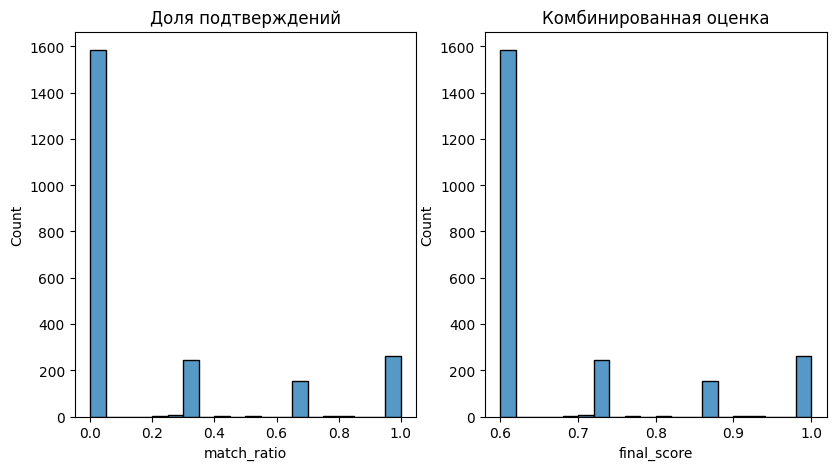

In [18]:
# Визуализация распределения оценок
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 2)
sns.histplot(merged_df['match_ratio'], bins=20)
plt.title('Доля подтверждений')

plt.subplot(1, 3, 3)
sns.histplot(merged_df['final_score'], bins=20)
plt.title('Комбинированная оценка')
plt.show()

**Вывод:**
- была выполнена агрегация по большинству голосов для экспертных данных
- объединенили экспертные и краудсорсинговые оценок, в результате чего получили итоговый скоринг `final_score`.
- высокая доля не подтвержденных описаний экспертами
- преобладающая комбинированная оценка - 0.6

## 2. Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

Поскольку в вашем PoC нет автоматического определения запрещённого контента, потребуется ручная или полуавтоматическая очистка данных.

**Определение критериев для удаления:**
- В метаданных/описании необходимо найти слова которые однозначно указывают на детей и на их основе исключить изображения. Данные следует подкрепить оценкой соответствия текста и изображения для повышения точности.
- Есть лица людей, похожих на детей (возраст < 16 лет).

Основные леммы, связанные с детьми (до 16 лет)

**1. Общие термины**
- child (ребёнок)
- kid (ребёнок, разг.)
- baby (младенец, малыш)
- toddler (ребёнок 1-3 лет)
- infant (младенец, до 1 года)
- minor (несовершеннолетний)
- juvenile (несовершеннолетний, юный)
- youngster (ребёнок, подросток)

**2. Возрастные группы**
- preschooler (дошкольник, 3-5 лет)
- schoolchild / schoolkid (школьник)
- preteen (ребёнок 9-12 лет)
- pupil (ученик начальной школы)

**3. Другие связанные термины**
- underage (несовершеннолетний)
- young + boy/girl (мальчик/девочка)
- little + kid/child/boy/girl (маленький ребёнок)

Попробуем сначало найти ключевые биграммы

In [19]:
unique_bigrams: set[str] = set()
for text in train_dataset_df["query_text"].unique():
    unique_bigrams.update(get_lemmas(text, 2))

In [20]:
for row in sorted(unique_bigrams, key=lambda x: x[0]):
    if {
        "underage", 
        "young",
        "little",
        "small",       
    } & set(row):
        print(row)

('a', 'small')
('a', 'little')
('a', 'young')
('and', 'young')
('five', 'young')
('four', 'small')
('little', 'girl')
('little', 'dog')
('little', 'brown')
('little', 'girls')
('little', 'boy')
('little', 'kid')
('little', 'drum')
('little', 'child')
('own', 'little')
('small', 'girl')
('small', 'art')
('small', 'white')
('small', 'dog')
('small', 'boat')
('small', 'poster')
('small', 'brown')
('small', 'black')
('small', 'tree')
('small', 'boy')
('small', 'animal')
('small', 'object')
('small', 'river')
('small', 'one')
('small', 'kangaroo')
('small', 'plane')
('small', 'crowd')
('small', 'child')
('small', 'waterfall')
('small', 'ball')
('smile', 'little')
('the', 'small')
('the', 'little')
('the', 'young')
('three', 'small')
('three', 'little')
('three', 'young')
('two', 'small')
('two', 'little')
('while', 'young')
('with', 'small')
('young', 'woman')
('young', 'man')
('young', 'men')
('young', 'asian')
('young', 'boy')
('young', 'person')
('young', 'adult')
('young', 'child')
('yo

Из полученного списка можно выделить несколько биграмм определяющих ребенка на изображении.

In [21]:
child_phrases: set[tuple[str, str]] = {
    ('little', 'boy'),
    ('little', 'kid'),
    ('little', 'child'),
    ('little', 'girl'),
    ('little', 'girls'),
    ('small', 'girl'),
    ('small', 'boy'),
    ('small', 'child'),
    ('young', 'boy'),
    ('young', 'child'),
    ('young', 'girl'),
}

Выполним поик по ключевым словам

In [22]:
unique_bigrams: set[str] = set()
for text in train_dataset_df["query_text"].unique():
    unique_bigrams.update(get_lemmas(text, 1))

In [23]:
for row in sorted(unique_bigrams, key=lambda x: x[0]):
    if {
        "child",
        "kid",
        "baby",
        "toddler", 
        "infant", 
        "minor", 
        "juvenile", 
        "youngster",
        "preschooler",
        "schoolchild",
        "schoolkid",
        "preteen",
        "pupil",
    } & set(row):
        print(row)

('baby',)
('child',)
('kid',)
('toddler',)


В результате получился следующий список:

In [24]:
child_words: set[tuple[str]] = {
    ('baby',),
    ('child',),
    ('kid',),
    ('toddler',),
}

In [25]:
def check_exception_words(text: str) -> int:
    lammas_1: set[tuple[str]] = get_lemmas(text, 1)
    lammas_2: set[tuple[str, str]] = get_lemmas(text, 2)
    if child_words & lammas_1:
        return 1
    if child_phrases & lammas_2:
        return 1
    return 0

In [26]:
# найдем слова исключения в тренировочных данных
train_dataset_df["has_child"] = train_dataset_df["query_text"].apply(check_exception_words)

In [27]:
# объеденим данные с оценками соответствия и тренировочную выборку
merged_train_dataset_df = pd.merge(train_dataset_df, merged_df[["image", "final_score"]], on=["image"], how="inner")
merged_train_dataset_df

image                     query_id  \
0      2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
1      2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
2      2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
3      2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4      2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
...                          ...                          ...   
13895  2112921744_92bf706805.jpg  2112921744_92bf706805.jpg#2   
13896  2112921744_92bf706805.jpg  2112921744_92bf706805.jpg#2   
13897  3651971126_309e6a5e22.jpg  3651971126_309e6a5e22.jpg#2   
13898  2292406847_f366350600.jpg  2292406847_f366350600.jpg#2   
13899  2292406847_f366350600.jpg  2292406847_f366350600.jpg#2   

                                              query_text  has_child  \
0      A young child is wearing blue goggles and sitt...          1   
1      A young child is wearing blue goggles and sitt...          1   
2      A young child is wearing blue goggles and sitt...          1   
3      A young child is wearing blue goggles and sitt...          1   
4      A young child is wearing blue goggles and sitt...          1   
...                                                  ...        ...   
13895       A dog stands on the side of a grassy cliff .          0   
13896       A dog stands on the side of a grassy cliff .          0   
13897                       A blurry photo of two dogs .          0   
13898                        A man rows his boat below .          0   
13899                        A man rows his boat below .          0   

       final_score  
0             0.60  
1             1.00  
2             0.60  
3             1.00  
4             0.60  
...            ...  
13895         0.60  
13896         0.60  
13897         0.73  
13898         0.60  
13899         0.60  

[13900 rows x 5 columns]

Отберем те записи у которых `final_score > 0.7` и `has_children = 1`. Значит, что картинка полностью соответствует описанию и в описании есть дети.

In [28]:
imgs_with_children = merged_train_dataset_df[
    (merged_train_dataset_df["has_child"] == 1) & (merged_train_dataset_df["final_score"] > 0.7)
]["image"].unique()
imgs_with_children.shape

(53,)

В результате 53 фотограции содержат изображения детей исходя из описания.

Попробуем найти лица людей, похожих на детей (возраст < 16 лет) используя детекцию изображения.

In [29]:
train_image_dir: list[str] = ["datasets", "train_images"]

In [30]:
# получим список уникальных фотографий на которых нет детей согласно описанию
imgs_without_children = train_dataset_df[~train_dataset_df["image"].isin(imgs_with_children)]["image"].unique()
print(imgs_without_children.shape)

(924,)


In [31]:
exclude_imgs: set[str] = set() 
for img_name in has_child(image_dir=Path(os.getcwd(), *train_image_dir), img_names=imgs_without_children):
    exclude_imgs.add(img_name)

2025-08-06 13:30:41.293730: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: INVALID_ARGUMENT: Must provide as many biases as the last dimension of the input tensor: [32] vs. [0,48,48,3]
2025-08-06 13:30:41.628930: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: INVALID_ARGUMENT: Must provide as many biases as the last dimension of the input tensor: [32] vs. [0,48,48,3]
2025-08-06 13:30:46.255847: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: INVALID_ARGUMENT: Must provide as many biases as the last dimension of the input tensor: [32] vs. [0,48,48,3]
2025-08-06 13:30:51.736326: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: INVALID_ARGUMENT: Must provide as many biases as the last dimension of the input tensor: [32] vs. [0,48,48,3]
2025-08-06 13:31:06.910771: I tensorflow/core/framework/local_rendez

In [32]:
# добавим изображение в список исключений 
for row in exclude_imgs:
    np.append(imgs_with_children, row)

In [33]:
# получим список уникальных изображений без детей
unique_imgs = pd.DataFrame(train_dataset_df[~train_dataset_df["image"].isin(imgs_with_children)]["image"].unique(), columns=["image"])

**Вывод:**
- для поиска детей до 16 лет использовал:
    - поиск по ключевым словам и оценку соответствия текста и изображения.
    - поиск по изображению лиц младше 16 лет.

## 3. Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

In [34]:
# Загружаем предобученную ResNet18
resnet = models.resnet18(pretrained=True)

# Удаляем последний полносвязный слой (avgpool и fc)
resnet = torch.nn.Sequential(*(list(resnet.children())[:-2]))  # Оставляем слои до avgpool

# Стандартные трансформации для ImageNet
preprocess = transforms.Compose([
    transforms.Resize(256),          # Изменение размера с сохранением пропорций
    transforms.CenterCrop(224),      # Центральное обрезание до 224x224
    transforms.ToTensor(),           # Преобразование в тензор
    transforms.Normalize(            # Нормализация
        mean=[0.485, 0.456, 0.406],  # Средние значения для ImageNet
        std=[0.229, 0.224, 0.225]   # Стандартные отклонения для ImageNet
    )
])

In [35]:
def get_image_features(image_name: str, image_dir: list[str]) -> np.ndarray:
    """
    Извлекает признаки (feature vector) из изображения с помощью предобученной модели.

    Параметры:
        image_name: Имя файла
        
    Возвращает:
        1D массив numpy с извлеченными признаками

    Описание работы:
        1. Загружает изображение по указанному пути
        2. Применяет препроцессинг (предполагается, что функция preprocess() определена где-то)
        3. Добавляет размерность батча для обработки моделью
        4. Пропускает изображение через модель без вычисления градиентов
        5. Усредняет признаки по пространственным измерениям (H и W)
        6. Преобразует результат в 1D numpy массив
    """

    # Загрузка и препроцессинг изображения
    img = Image.open(Path(*image_dir, image_name))
    img_t = preprocess(img)
    batch_t = torch.unsqueeze(img_t, 0)  # Добавляем размерность батча

    # Извлечение признаков
    with torch.no_grad():  # Отключаем вычисление градиентов
        features = resnet(batch_t)

    # Преобразуем 4D-тензор в 1D-вектор (усреднение по пространственным измерениям)
    features = torch.mean(features, dim=[2, 3]).squeeze()

    return features.numpy()

In [36]:
# Переводим к векторам изображения
image_features = np.stack(unique_imgs["image"].apply(lambda x: get_image_features(x, train_image_dir)))
image_feat_df = unique_imgs.join(pd.DataFrame(image_features, columns=[f"img_feat_{i}" for i in range(image_features.shape[1])]), how="inner")
image_feat_df

image  img_feat_0  img_feat_1  img_feat_2  \
0    2718495608_d8533e3ac5.jpg    0.940014    0.951113    0.938394   
1    3181701312_70a379ab6e.jpg    0.833205    0.943270    0.993235   
2    3207358897_bfa61fa3c6.jpg    0.865444    0.974603    0.919615   
3    3286822339_5535af6b93.jpg    0.862807    0.971047    0.871881   
4    3360930596_1e75164ce6.jpg    0.891921    0.977276    0.865718   
..                         ...         ...         ...         ...   
919  2061144717_5b3a1864f0.jpg    0.918341    1.016984    0.919145   
920  2196107384_361d73a170.jpg    0.873897    1.044450    1.073261   
921  2112921744_92bf706805.jpg    0.926892    0.916405    0.880644   
922  3651971126_309e6a5e22.jpg    0.981912    0.927888    0.835272   
923  2292406847_f366350600.jpg    0.912324    0.889677    0.976473   

     img_feat_3  img_feat_4  img_feat_5  img_feat_6  img_feat_7  img_feat_8  \
0      1.088151    0.999733    0.881681    0.969369    1.184438    0.980772   
1      1.115214    0.919796    0.853583    0.902020    1.134699    0.961402   
2      1.004686    0.997461    0.889810    0.946888    1.223390    1.013942   
3      1.027260    0.978041    0.942459    1.039212    1.161621    0.950452   
4      1.073742    0.893586    0.929700    0.898458    1.240413    0.977137   
..          ...         ...         ...         ...         ...         ...   
919    1.072676    0.946130    0.931285    0.926375    1.185830    0.907908   
920    1.102473    0.915143    0.961400    0.943653    1.176227    1.036822   
921    1.018692    0.926445    0.826721    0.957969    1.159893    0.946292   
922    1.095697    0.954528    0.875922    0.906153    1.151213    0.971512   
923    0.994607    0.949550    0.880066    0.843007    1.139344    0.888142   

     ...  img_feat_502  img_feat_503  img_feat_504  img_feat_505  \
0    ...      0.923946      0.869106      0.893505      0.832936   
1    ...      0.968411      0.908960      0.936343      0.839557   
2    ...      0.923957      0.900126      0.899411      0.863323   
3    ...      0.943302      0.881707      0.921813      0.928709   
4    ...      0.950242      0.890476      0.853390      0.920935   
..   ...           ...           ...           ...           ...   
919  ...      0.956422      0.925520      0.936652      0.877548   
920  ...      0.947898      0.870984      0.930988      0.916083   
921  ...      1.006909      0.846725      0.846437      0.842777   
922  ...      0.966225      0.876983      0.924102      0.848942   
923  ...      0.978021      0.891246      0.924788      0.882654   

     img_feat_506  img_feat_507  img_feat_508  img_feat_509  img_feat_510  \
0        1.104018      1.017534      0.976502      0.928059      0.998232   
1        1.046722      0.971603      1.006916      0.979019      1.017599   
2        1.080339      0.959412      1.012937      0.896116      1.016931   
3        1.103197      1.046197      0.938841      0.905221      1.054273   
4        1.174702      0.975136      0.935606      0.938209      1.023520   
..            ...           ...           ...           ...           ...   
919      1.094697      1.034892      0.969774      0.908152      0.977581   
920      1.058877      1.067008      0.940301      0.955191      0.931977   
921      1.044329      0.989667      0.988182      0.947416      1.091076   
922      1.066060      0.940541      0.959630      0.937841      0.920551   
923      1.080199      1.040615      0.919686      0.918759      0.946113   

     img_feat_511  
0        0.939887  
1        0.943973  
2        0.945110  
3        0.980222  
4        0.979298  
..            ...  
919      0.970241  
920      0.919212  
921      0.891425  
922      1.005162  
923      0.945678  

[924 rows x 513 columns]

**Вывод:**
- для векторизации изображений использовали модель `ResNet18`
- векторизацию применили к датасету с ранее отобранными изображениями (без детей младше 16 лет)

## 4. Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.


Для векторизации текста будем использовать `word2vec` модель.

**Плюсы**:
- Учитывает семантику слов
- Фиксированный размер вектора (300 в примере)
- Улавливает отношения между словами
- 
**Минусы**:
- Требует обучения (или загрузки предобученной модели)
- Потеря порядка слов (если просто усреднять)
- Не учитывает полный контекст предложения

Для баланса качества и скорости - `Word2Vec` (загрузим предобученную модель)

In [37]:
# Загрузка предобученной модели (300-мерные векторы)
w2v_model = api.load('word2vec-google-news-300')

In [38]:
def text_vector_pretrained(text: str) -> np.ndarray:
    """
    Преобразует текст в векторное представление (документный эмбеддинг) 
    с использованием предобученной word2vec модели.
    
    Для каждого слова в тексте извлекается вектор из word2vec модели,
    затем возвращается среднее всех векторов слов (усредненный эмбеддинг документа).
    
    Параметры:
        text: Входной текст для векторного представления
        
    Возвращает:
        Векторное представление документа (усредненный вектор слов).
        Если ни одно слово не найдено в модели, возвращается нулевой вектор
        размерности w2v_model.vector_size.
    """
    words = nltk.tokenize.word_tokenize(text.lower())
    word_vectors = [w2v_model[word] for word in words if word in w2v_model]
    if len(word_vectors) == 0:
        return np.zeros(w2v_model.vector_size)
    return np.mean(word_vectors, axis=0)

Исключим из выборки изображения на которых содержатся изображения детей а так же избавимся от дубликатов в данных за счет группировки. Для `final_score` посчитает среднее. 

In [39]:
unique_text_df = (
    pd.merge(
        merged_train_dataset_df[["image", "query_text", "final_score"]], 
        unique_imgs, 
        on=["image"], 
        how="inner",
    )
    .groupby(["image", "query_text"])["final_score"]
    .mean()
    .round(2)
    .reset_index()
)
unique_text_df

image  \
0    1056338697_4f7d7ce270.jpg   
1    1084040636_97d9633581.jpg   
2    1096395242_fc69f0ae5a.jpg   
3    1107246521_d16a476380.jpg   
4    1119015538_e8e796281e.jpg   
..                         ...   
805   925491651_57df3a5b36.jpg   
806   929679367_ff8c7df2ee.jpg   
807    96420612_feb18fc6c6.jpg   
808   968081289_cdba83ce2e.jpg   
809   997722733_0cb5439472.jpg   

                                            query_text  final_score  
0    A woman is signaling is to traffic , as seen f...         0.60  
1             A white dog has its head on the ground .         0.66  
2    A young boy with his foot outstretched aims a ...         0.60  
3              A black dog pounces to get a rope toy .         0.64  
4    A small dogs ears stick up as it runs in the g...         0.74  
..                                                 ...          ...  
805                       A tan dog jumps into water .         0.67  
806  A puppy is playing with a tennis ball on a wel...         0.60  
807  A man with a wake-board is diving over a surfa...         0.60  
808     Two boys jumping off the pier into the water .         0.60  
809  A person in a red shirt climbing up a rock fac...         0.64  

[810 rows x 3 columns]

In [40]:
text_embeddings = np.stack(unique_text_df["query_text"].apply(text_vector_pretrained))

# Преобразуем в DataFrame для удобства
text_emb_df = pd.DataFrame(text_embeddings, columns=[f"text_feat_{i}" for i in range(text_embeddings.shape[1])])
text_emb_df = unique_text_df.join(text_emb_df, how="inner")
text_emb_df

image  \
0    1056338697_4f7d7ce270.jpg   
1    1084040636_97d9633581.jpg   
2    1096395242_fc69f0ae5a.jpg   
3    1107246521_d16a476380.jpg   
4    1119015538_e8e796281e.jpg   
..                         ...   
805   925491651_57df3a5b36.jpg   
806   929679367_ff8c7df2ee.jpg   
807    96420612_feb18fc6c6.jpg   
808   968081289_cdba83ce2e.jpg   
809   997722733_0cb5439472.jpg   

                                            query_text  final_score  \
0    A woman is signaling is to traffic , as seen f...         0.60   
1             A white dog has its head on the ground .         0.66   
2    A young boy with his foot outstretched aims a ...         0.60   
3              A black dog pounces to get a rope toy .         0.64   
4    A small dogs ears stick up as it runs in the g...         0.74   
..                                                 ...          ...   
805                       A tan dog jumps into water .         0.67   
806  A puppy is playing with a tennis ball on a wel...         0.60   
807  A man with a wake-board is diving over a surfa...         0.60   
808     Two boys jumping off the pier into the water .         0.60   
809  A person in a red shirt climbing up a rock fac...         0.64   

     text_feat_0  text_feat_1  text_feat_2  text_feat_3  text_feat_4  \
0       0.063117     0.004301     0.030979     0.003465    -0.077121   
1       0.013199     0.006104     0.053913     0.032593    -0.051010   
2       0.081098     0.140538     0.033805     0.036749    -0.009532   
3       0.117920     0.049764    -0.144135     0.038717    -0.077148   
4       0.052557     0.058390     0.042436     0.110335    -0.115266   
..           ...          ...          ...          ...          ...   
805     0.007153     0.038940    -0.027734     0.016089     0.020654   
806    -0.007815     0.128632     0.042824     0.076792    -0.002452   
807    -0.022089     0.044141     0.080750     0.001538    -0.094556   
808    -0.008830     0.049072     0.022627    -0.022796    -0.023214   
809     0.060527     0.006404     0.075612     0.049271    -0.050964   

     text_feat_5  text_feat_6  ...  text_feat_290  text_feat_291  \
0      -0.014581     0.017198  ...      -0.110392      -0.042630   
1      -0.077271     0.033066  ...      -0.105212       0.002426   
2      -0.045988     0.061691  ...      -0.100475       0.023320   
3      -0.119344     0.072957  ...      -0.120239       0.098572   
4      -0.068594     0.063665  ...      -0.051442       0.045416   
..           ...          ...  ...            ...            ...   
805    -0.122974     0.010712  ...      -0.067859       0.017188   
806    -0.094523     0.002472  ...      -0.134074       0.064237   
807    -0.007031     0.006229  ...      -0.070050      -0.010483   
808    -0.181790    -0.018826  ...      -0.037733       0.003052   
809    -0.034505     0.039700  ...      -0.033061      -0.039876   

     text_feat_292  text_feat_293  text_feat_294  text_feat_295  \
0        -0.018759       0.042413      -0.039280       0.045844   
1        -0.126671       0.089081       0.032776       0.018246   
2        -0.143912       0.009120      -0.028109      -0.040292   
3        -0.255046       0.125407      -0.008799      -0.084340   
4        -0.124218       0.063316       0.033100       0.044616   
..             ...            ...            ...            ...   
805      -0.191913       0.108667      -0.021387      -0.002783   
806      -0.148104      -0.025238       0.027323       0.085424   
807      -0.123788       0.035132       0.010123       0.040625   
808      -0.126044      -0.016595      -0.051337      -0.003893   
809      -0.093058       0.036893      -0.028056       0.007039   

     text_feat_296  text_feat_297  text_feat_298  text_feat_299  
0         0.002697      -0.033583       0.123983       0.029961  
1         0.087769       0.077431      -0.053801       0.042006  
2         0.034548      -0.043915      -0.045135      -0.025383  
3         0.

Уберем из данных лишние колонки

In [41]:
text_emb_df = text_emb_df.drop("query_text", axis=1)
text_emb_df

image  final_score  text_feat_0  text_feat_1  \
0    1056338697_4f7d7ce270.jpg         0.60     0.063117     0.004301   
1    1084040636_97d9633581.jpg         0.66     0.013199     0.006104   
2    1096395242_fc69f0ae5a.jpg         0.60     0.081098     0.140538   
3    1107246521_d16a476380.jpg         0.64     0.117920     0.049764   
4    1119015538_e8e796281e.jpg         0.74     0.052557     0.058390   
..                         ...          ...          ...          ...   
805   925491651_57df3a5b36.jpg         0.67     0.007153     0.038940   
806   929679367_ff8c7df2ee.jpg         0.60    -0.007815     0.128632   
807    96420612_feb18fc6c6.jpg         0.60    -0.022089     0.044141   
808   968081289_cdba83ce2e.jpg         0.60    -0.008830     0.049072   
809   997722733_0cb5439472.jpg         0.64     0.060527     0.006404   

     text_feat_2  text_feat_3  text_feat_4  text_feat_5  text_feat_6  \
0       0.030979     0.003465    -0.077121    -0.014581     0.017198   
1       0.053913     0.032593    -0.051010    -0.077271     0.033066   
2       0.033805     0.036749    -0.009532    -0.045988     0.061691   
3      -0.144135     0.038717    -0.077148    -0.119344     0.072957   
4       0.042436     0.110335    -0.115266    -0.068594     0.063665   
..           ...          ...          ...          ...          ...   
805    -0.027734     0.016089     0.020654    -0.122974     0.010712   
806     0.042824     0.076792    -0.002452    -0.094523     0.002472   
807     0.080750     0.001538    -0.094556    -0.007031     0.006229   
808     0.022627    -0.022796    -0.023214    -0.181790    -0.018826   
809     0.075612     0.049271    -0.050964    -0.034505     0.039700   

     text_feat_7  ...  text_feat_290  text_feat_291  text_feat_292  \
0      -0.085164  ...      -0.110392      -0.042630      -0.018759   
1      -0.155106  ...      -0.105212       0.002426      -0.126671   
2      -0.114293  ...      -0.100475       0.023320      -0.143912   
3      -0.020020  ...      -0.120239       0.098572      -0.255046   
4      -0.057318  ...      -0.051442       0.045416      -0.124218   
..           ...  ...            ...            ...            ...   
805    -0.105762  ...      -0.067859       0.017188      -0.191913   
806    -0.119425  ...      -0.134074       0.064237      -0.148104   
807    -0.132513  ...      -0.070050      -0.010483      -0.123788   
808    -0.074972  ...      -0.037733       0.003052      -0.126044   
809    -0.105616  ...      -0.033061      -0.039876      -0.093058   

     text_feat_293  text_feat_294  text_feat_295  text_feat_296  \
0         0.042413      -0.039280       0.045844       0.002697   
1         0.089081       0.032776       0.018246       0.087769   
2         0.009120      -0.028109      -0.040292       0.034548   
3         0.125407      -0.008799      -0.084340       0.077723   
4         0.063316       0.033100       0.044616       0.013489   
..             ...            ...            ...            ...   
805       0.108667      -0.021387      -0.002783       0.002197   
806      -0.025238       0.027323       0.085424       0.034475   
807       0.035132       0.010123       0.040625       0.014709   
808      -0.016595      -0.051337      -0.003893      -0.013455   
809       0.036893      -0.028056       0.007039       0.032125   

     text_feat_297  text_feat_298  text_feat_299  
0        -0.033583       0.123983       0.029961  
1         0.077431      -0.053801       0.042006  
2        -0.043915      -0.045135      -0.025383  
3         0.114543      -0.125448       0.034180  
4         0.064231      -0.073880      -0.004006  
..             ...            ...            ...  
805       0.106506      -0.035010       0.028589  
806      -0.015350      -0.053304       0.039469  
807      -0.053522       0.028485      -0.032324  
808      -0.035570      -0.017049       0.015286  
809       0.003502      -0.027049       0.066523  

[810 rows x 302 columns]

**Вывод:**
- для векторизации текста из пользовал `word2vec` с предобученной моделью `word2vec-google-news-300`.
- результат сохранил в датафрейм сохранив колонки `image` и `final_score` (целевой признак) для дальнейшего объединения с датафреймом векторизованных картинок.

## 5. Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

In [42]:
final_data_df = pd.merge(
    text_emb_df,
    image_feat_df,
    on="image", 
    how="inner"
)
final_data_df

image  final_score  text_feat_0  text_feat_1  \
0    1056338697_4f7d7ce270.jpg         0.60     0.063117     0.004301   
1    1084040636_97d9633581.jpg         0.66     0.013199     0.006104   
2    1096395242_fc69f0ae5a.jpg         0.60     0.081098     0.140538   
3    1107246521_d16a476380.jpg         0.64     0.117920     0.049764   
4    1119015538_e8e796281e.jpg         0.74     0.052557     0.058390   
..                         ...          ...          ...          ...   
805   925491651_57df3a5b36.jpg         0.67     0.007153     0.038940   
806   929679367_ff8c7df2ee.jpg         0.60    -0.007815     0.128632   
807    96420612_feb18fc6c6.jpg         0.60    -0.022089     0.044141   
808   968081289_cdba83ce2e.jpg         0.60    -0.008830     0.049072   
809   997722733_0cb5439472.jpg         0.64     0.060527     0.006404   

     text_feat_2  text_feat_3  text_feat_4  text_feat_5  text_feat_6  \
0       0.030979     0.003465    -0.077121    -0.014581     0.017198   
1       0.053913     0.032593    -0.051010    -0.077271     0.033066   
2       0.033805     0.036749    -0.009532    -0.045988     0.061691   
3      -0.144135     0.038717    -0.077148    -0.119344     0.072957   
4       0.042436     0.110335    -0.115266    -0.068594     0.063665   
..           ...          ...          ...          ...          ...   
805    -0.027734     0.016089     0.020654    -0.122974     0.010712   
806     0.042824     0.076792    -0.002452    -0.094523     0.002472   
807     0.080750     0.001538    -0.094556    -0.007031     0.006229   
808     0.022627    -0.022796    -0.023214    -0.181790    -0.018826   
809     0.075612     0.049271    -0.050964    -0.034505     0.039700   

     text_feat_7  ...  img_feat_502  img_feat_503  img_feat_504  img_feat_505  \
0      -0.085164  ...      0.930916      0.892060      0.942388      0.871030   
1      -0.155106  ...      0.914218      0.884646      0.861099      0.949006   
2      -0.114293  ...      0.959606      0.899314      0.932473      0.931241   
3      -0.020020  ...      0.875011      0.900400      0.956824      0.884641   
4      -0.057318  ...      0.919021      0.912441      0.888513      0.847867   
..           ...  ...           ...           ...           ...           ...   
805    -0.105762  ...      0.934113      0.890021      0.870014      0.922941   
806    -0.119425  ...      1.010357      0.914478      0.928632      0.916955   
807    -0.132513  ...      0.948958      0.912437      0.884068      0.885881   
808    -0.074972  ...      0.967360      0.892874      0.891172      0.850577   
809    -0.105616  ...      0.970569      0.892320      0.864574      0.853875   

     img_feat_506  img_feat_507  img_feat_508  img_feat_509  img_feat_510  \
0        1.126657      0.981160      0.863311      0.985003      0.927059   
1        1.009969      1.004848      0.928155      0.893897      1.004511   
2        1.101306      1.047065      0.991871      0.968213      1.077780   
3        1.094778      1.052222      0.993641      0.866326      1.091956   
4        1.078310      1.056662      0.928688      0.956743      1.086328   
..            ...           ...           ...           ...           ...   
805      1.147946      0.975139      0.903255      0.906445      1.082427   
806      1.098013      1.030868      0.934440      0.948870      1.049622   
807      1.046455      0.917046      0.919331      0.918342      1.039248   
808      1.105393      1.000033      0.980942      0.969040      1.089691   
809      1.159862      1.000617      0.990649      0.920314      1.060434   

     img_feat_511  
0        0.895732  
1        0.958424  
2        0.943262  
3        1.010778  
4        0.987380  
..            ...  
805      0.976044  
806      0.945991  
807      0.964126  
808      0.966866  
809      0.946056  

[810 rows x 814 columns]

## 6. Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

Для данной задачи была выбрана `RandomForestRegressor` по нескольким ключевым причинам:
- Наша целевая переменная `final_score` — это непрерывное значение от 0 до 1 (фактически вероятность соответствия)
- Данная модель идеально подходит для регрессионных задач с такими ограниченными диапазонами
- Ансамблевая природа RandomForest снижает влияние выбросов
- По сравнению с линейными моделями (типа `LogisticRegression`):
    - Лучше улавливает нелинейные зависимости между текстовыми и визуальными признаками
    - Не требует ручной настройки взаимодействий фич
- По сравнению с нейросетями:
    - Быстрее обучается на небольших/средних датасетах
    - Меньше риск переобучения без сложных техник регуляризации

In [43]:
# выделим целевой признак и входные признаки
X = final_data_df.drop(["final_score", "image"], axis=1)
y = final_data_df["final_score"]

In [44]:
groups = final_data_df['image']

# Разделение на train и test с учетом групп (изображений)
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=X, y=y, groups=groups))

X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]

In [45]:
# Обучение модели (Random Forest)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [46]:
# Оценка модели
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

Метрика `Mean Squared Error (MSE)` для оценки модели была выбрана по следующим причинам:
- Целевая переменная `final_score` — непрерывная величина (0-1)
- MSE классически используется для регрессии
- MSE сильнее штрафует крупные отклонения (квадратичная функция)
- RandomForestRegressor минимизирует MSE по умолчанию

In [47]:
print(f"Train MSE: {mean_squared_error(y_train, train_pred)}")
print(f"Test MSE: {mean_squared_error(y_test, test_pred)}")

Train MSE: 0.0013940583950617547
Test MSE: 0.010254291152263383


**Вывод:**
- Для обучения была выбрана модель `Random Forest`
- Для оценки качества модели была выбрана метрика `Mean Squared Error (MSE)`
- В результате модель на тренировочной и тестовой выборках показала хороший результат

## 7. Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

Векторизация тестовых изображений

In [59]:
# Переводим к векторам тестовые изображения
test_image_dir: list[str] = ["datasets", "test_images"]

test_image_features = np.stack(test_images_df["image"].apply(lambda x: get_image_features(x, test_image_dir)))
test_image_feat_df = test_images_df.join(
    pd.DataFrame(test_image_features, columns=[f"img_feat_{i}" for i in range(test_image_features.shape[1])]),
    how="inner",
)
test_image_feat_df

image  img_feat_0  img_feat_1  img_feat_2  img_feat_3  \
0   3356748019_2251399314.jpg    0.883691    0.897215    0.986507    1.062083   
1   2887171449_f54a2b9f39.jpg    0.963516    0.876371    0.916414    1.063413   
2   3089107423_81a24eaf18.jpg    0.902065    0.961907    0.947972    1.042552   
3   1429546659_44cb09cbe2.jpg    0.911333    0.922644    0.881538    1.037105   
4   1177994172_10d143cb8d.jpg    0.850434    1.002250    0.941506    1.004534   
..                        ...         ...         ...         ...         ...   
95  2431120202_b24fe2333a.jpg    0.914335    0.915186    0.871585    1.023508   
96  2399219552_bbba0a9a59.jpg    0.917610    0.859318    0.943172    1.000377   
97  3091962081_194f2f3bd4.jpg    0.873533    0.936344    0.943617    1.057121   
98  2670637584_d96efb8afa.jpg    0.897664    0.984885    0.927986    1.048832   
99  2346402952_e47d0065b6.jpg    0.919440    0.927214    0.929305    1.051014   

    img_feat_4  img_feat_5  img_feat_6  img_feat_7  img_feat_8  ...  \
0     0.959828    0.877184    0.972500    1.231512    0.922816  ...   
1     0.956974    0.878568    0.960605    1.120901    0.988920  ...   
2     1.006664    0.899958    0.963056    1.143182    0.949710  ...   
3     0.958126    0.872101    0.902007    1.178086    0.874957  ...   
4     1.012334    0.912299    0.917419    1.179737    1.007115  ...   
..         ...         ...         ...         ...         ...  ...   
95    0.931667    0.860818    0.957389    1.219299    0.975402  ...   
96    0.900635    0.933736    0.950252    1.248983    0.981798  ...   
97    0.915188    0.854767    0.936979    1.130478    0.930836  ...   
98    0.889265    0.833807    0.842802    1.224714    1.004586  ...   
99    0.969934    0.943291    0.944856    1.243554    0.974598  ...   

    img_feat_502  img_feat_503  img_feat_504  img_feat_505  img_feat_506  \
0       0.952504      0.878908      0.887797      0.848691      1.196882   
1       0.995972      0.890870      0.914927      0.923441      1.086438   
2       0.904090      0.816432      0.914064      0.943684      1.056424   
3       0.982759      0.927641      0.865056      0.933800      1.077061   
4       0.912591      0.958528      0.913258      0.881534      1.175929   
..           ...           ...           ...           ...           ...   
95      0.896230      0.882321      0.939583      0.808594      1.156756   
96      0.843786      0.897312      0.973482      0.844192      1.044473   
97      0.945729      0.876511      0.884430      0.860346      1.087358   
98      0.919809      0.929746      0.817373      0.920802      1.112731   
99      0.915599      0.839539      0.877418      0.901235      1.145010   

    img_feat_507  img_feat_508  img_feat_509  img_feat_510  img_feat_511  
0       1.036903      0.937270      0.924431      1.098992      1.040970  
1       0.960539      0.919661      0.875219      1.075938      0.949920  
2       0.946282      0.915146      0.921580      1.018599      0.931128  
3       1.018817      0.916865      0.949503      1.109643      0.949175  
4       1.006326      0.954897      0.901063      1.071711      1.013064  
..           ...           ...           ...           ...           ...  
95      1.012622      0.982382      0.916820      1.083402      0.936572  
96      1.033499      0.908242      0.865701      1.007238      0.987267  
97      1.059863      0.919460      0.924834      1.026845      1.033934  
98      1.033732      1.003301      0.933237      1.066123      1.015938  
99      0.971026      0.918005      0.971691      0.977799      0.981309  

[100 rows x 513 columns]

Векторизация тестовых запросов

In [60]:
test_text_embeddings = np.stack(test_queries_df["query_text"].apply(text_vector_pretrained))

# Преобразуем в DataFrame для удобства
test_text_emb_df = pd.DataFrame(test_text_embeddings, columns=[f"text_feat_{i}" for i in range(test_text_embeddings.shape[1])])
test_text_emb_df = test_queries_df.join(test_text_emb_df, how="inner")
test_text_emb_df

query_id  \
0    1177994172_10d143cb8d.jpg#0   
1    1177994172_10d143cb8d.jpg#1   
2    1177994172_10d143cb8d.jpg#2   
3    1177994172_10d143cb8d.jpg#3   
4    1177994172_10d143cb8d.jpg#4   
..                           ...   
495   989851184_9ef368e520.jpg#0   
496   989851184_9ef368e520.jpg#1   
497   989851184_9ef368e520.jpg#2   
498   989851184_9ef368e520.jpg#3   
499   989851184_9ef368e520.jpg#4   

                                            query_text  \
0    Two blonde boys , one in a camouflage shirt an...   
1    Two boys are squirting water guns at each other .   
2              Two boys spraying each other with water   
3    Two children wearing jeans squirt water at eac...   
4    Two young boys are squirting water at each oth...   
..                                                 ...   
495          A black dog has a dumbbell in his mouth .   
496  A black dog has a dumbbell in his mouth lookin...   
497  A black dog holding a weight in its mouth stan...   
498  A black dog holds a small white dumbbell in it...   
499  The black dog has a toy in its mouth and a per...   

                         image  text_feat_0  text_feat_1  text_feat_2  \
0    1177994172_10d143cb8d.jpg     0.025295     0.055770     0.041673   
1    1177994172_10d143cb8d.jpg    -0.031698     0.006727     0.115109   
2    1177994172_10d143cb8d.jpg    -0.013811     0.025042     0.023206   
3    1177994172_10d143cb8d.jpg    -0.015164    -0.045380     0.004066   
4    1177994172_10d143cb8d.jpg    -0.021898     0.022352     0.063053   
..                         ...          ...          ...          ...   
495   989851184_9ef368e520.jpg     0.126256     0.011980     0.032030   
496   989851184_9ef368e520.jpg     0.097224     0.017710     0.052713   
497   989851184_9ef368e520.jpg     0.118140    -0.002734     0.071881   
498   989851184_9ef368e520.jpg     0.104112     0.017144     0.042636   
499   989851184_9ef368e520.jpg     0.105280     0.004736     0.053619   

     text_feat_3  text_feat_4  text_feat_5  text_feat_6  ...  text_feat_290  \
0       0.045396    -0.012358    -0.065295     0.003422  ...      -0.073462   
1       0.028890    -0.038690    -0.031826     0.006819  ...      -0.048923   
2       0.043213     0.002119    -0.047668    -0.041770  ...      -0.023804   
3       0.136393    -0.019545     0.000949     0.032047  ...       0.010457   
4       0.016595    -0.030253    -0.021166     0.007768  ...      -0.004896   
..           ...          ...          ...          ...  ...            ...   
495     0.053693    -0.016061     0.035924    -0.003627  ...      -0.088309   
496     0.062885    -0.037138     0.005761     0.025970  ...      -0.047908   
497     0.035529    -0.032495    -0.022607     0.023315  ...      -0.094167   
498     0.036580     0.003228    -0.028646     0.039822  ...      -0.044260   
499     0.067705    -0.069891    -0.024880     0.009078  ...      -0.109000   

     text_feat_291  text_feat_292  text_feat_293  text_feat_294  \
0        -0.024172      -0.070809       0.004667       0.000350   
1        -0.005588      -0.028158      -0.013021      -0.044200   
2         0.029336      -0.058105      -0.054234      -0.051531   
3         0.008708      -0.038479      -0.028666      -0.002112   
4         0.009711      -0.037923      -0.046984      -0.054182   
..             ...            ...            ...            ...   
495       0.005319      -0.141061       0.021415       0.034982   
496      -0.001324      -0.095774       0.023184       0.027017   
497       0.009171      -0.113342       0.014429       0.032068   
498      -0.011709      -0.161404       0.032172       0.030382   
499       0.023485      -0.148476       0.045255       0.024015   

     text_feat_295  text_feat_296  text_feat_297  text_feat_298  text_feat_299  
0        -0.034102      -0.021265      -0.061446       0.017106       0.050011  
1         0.006775      -0.011149      -0.070075      -0.032810       0.036323  
2         0.065778  

In [67]:
# Выбираем случайные 10 запросов
sample_queries = test_queries_df.sample(10, random_state=42)
sample_queries.head(10)

query_id  \
361  3482859574_3908de3427.jpg#1   
73   2141713971_e25eb12712.jpg#3   
374  3488087117_2719647989.jpg#4   
155   269650644_059a84ece5.jpg#0   
104  2428094795_d3a8f46046.jpg#4   
394  3553476195_fb3747d7c1.jpg#4   
377  3514297698_0512623955.jpg#2   
124  2505056124_1276e8dbcb.jpg#4   
68   2121140070_a09644550b.jpg#3   
450   607339469_af851c4119.jpg#0   

                                            query_text  \
361  A group of girls who are gothically dressed st...   
73   A woman and girl riding downhill on a sled wit...   
374                               The dog is running .   
155  A group of people are ice skating in a big city .   
104  Little kid in blue coat and hat riding a tricy...   
394       Two black dogs fighting over an orange toy .   
377      A dog jumping for a tennis ball near an ocean   
124                        Boy flying a distant kite .   
68                        kids play ultimate Frisbee .   
450             A girl in a purple shirt feeding ducks   

                         image  
361  3482859574_3908de3427.jpg  
73   2141713971_e25eb12712.jpg  
374  3488087117_2719647989.jpg  
155   269650644_059a84ece5.jpg  
104  2428094795_d3a8f46046.jpg  
394  3553476195_fb3747d7c1.jpg  
377  3514297698_0512623955.jpg  
124  2505056124_1276e8dbcb.jpg  
68   2121140070_a09644550b.jpg  
450   607339469_af851c4119.jpg

In [78]:
# объеденяем данные
test_final_df = (
    pd.merge(
        test_text_emb_df,
        test_image_feat_df,
        on="image", 
        how="inner"
    )
    .drop(["query_id", "query_text"], axis=1)
    .drop_duplicates()
)
test_final_df

image  text_feat_0  text_feat_1  text_feat_2  \
0    1177994172_10d143cb8d.jpg     0.025295     0.055770     0.041673   
1    1177994172_10d143cb8d.jpg    -0.031698     0.006727     0.115109   
2    1177994172_10d143cb8d.jpg    -0.013811     0.025042     0.023206   
3    1177994172_10d143cb8d.jpg    -0.015164    -0.045380     0.004066   
4    1177994172_10d143cb8d.jpg    -0.021898     0.022352     0.063053   
..                         ...          ...          ...          ...   
495   989851184_9ef368e520.jpg     0.126256     0.011980     0.032030   
496   989851184_9ef368e520.jpg     0.097224     0.017710     0.052713   
497   989851184_9ef368e520.jpg     0.118140    -0.002734     0.071881   
498   989851184_9ef368e520.jpg     0.104112     0.017144     0.042636   
499   989851184_9ef368e520.jpg     0.105280     0.004736     0.053619   

     text_feat_3  text_feat_4  text_feat_5  text_feat_6  text_feat_7  \
0       0.045396    -0.012358    -0.065295     0.003422    -0.112573   
1       0.028890    -0.038690    -0.031826     0.006819    -0.038845   
2       0.043213     0.002119    -0.047668    -0.041770    -0.068621   
3       0.136393    -0.019545     0.000949     0.032047    -0.107734   
4       0.016595    -0.030253    -0.021166     0.007768    -0.028293   
..           ...          ...          ...          ...          ...   
495     0.053693    -0.016061     0.035924    -0.003627    -0.078596   
496     0.062885    -0.037138     0.005761     0.025970    -0.097252   
497     0.035529    -0.032495    -0.022607     0.023315    -0.039160   
498     0.036580     0.003228    -0.028646     0.039822    -0.075304   
499     0.067705    -0.069891    -0.024880     0.009078    -0.066639   

     text_feat_8  ...  img_feat_502  img_feat_503  img_feat_504  img_feat_505  \
0       0.045199  ...      0.912591      0.958528      0.913258      0.881534   
1      -0.015842  ...      0.912591      0.958528      0.913258      0.881534   
2       0.016950  ...      0.912591      0.958528      0.913258      0.881534   
3       0.030996  ...      0.912591      0.958528      0.913258      0.881534   
4      -0.019640  ...      0.912591      0.958528      0.913258      0.881534   
..           ...  ...           ...           ...           ...           ...   
495     0.036970  ...      0.946478      0.860201      0.935376      0.855006   
496     0.042483  ...      0.946478      0.860201      0.935376      0.855006   
497     0.110498  ...      0.946478      0.860201      0.935376      0.855006   
498     0.048435  ...      0.946478      0.860201      0.935376      0.855006   
499     0.068304  ...      0.946478      0.860201      0.935376      0.855006   

     img_feat_506  img_feat_507  img_feat_508  img_feat_509  img_feat_510  \
0        1.175929      1.006326      0.954897      0.901063      1.071711   
1        1.175929      1.006326      0.954897      0.901063      1.071711   
2        1.175929      1.006326      0.954897      0.901063      1.071711   
3        1.175929      1.006326      0.954897      0.901063      1.071711   
4        1.175929      1.006326      0.954897      0.901063      1.071711   
..            ...           ...           ...           ...           ...   
495      1.096612      0.993904      0.952535      0.929301      1.088616   
496      1.096612      0.993904      0.952535      0.929301      1.088616   
497      1.096612      0.993904      0.952535      0.929301      1.088616   
498      1.096612      0.993904      0.952535      0.929301      1.088616   
499      1.096612      0.993904      0.952535      0.929301      1.088616   

     img_feat_511  
0        1.013064  
1        1.013064  
2        1.013064  
3        1.013064  
4        1.013064  
..            ...  
495      0.968979  
496      0.968979  
497      0.968979  
498      0.968979  
499      0.968979  

[500 rows x 813 columns]

In [90]:
results: dict[str, Any] = []

for _, row in sample_queries.iterrows():

    scores: list[tulpe[str, float]] = []
    
    for _, data in test_final_df[test_final_df["image"] == row.image].drop("image", axis=1).iterrows():
        # Предсказываем релевантность
        score = model.predict([data.to_list()])[0]
        scores.append((row.image, score))
    
    # Сортируем по убыванию релевантности
    scores.sort(key=lambda x: x[1], reverse=True)
    top_image = scores[0][0]
    
    results.append({
        'query_id': row['query_id'],
        'query_text': row['query_text'],
        'top_image': top_image,
        'score': scores[0][1]
    })

results

[{'query_id': '3482859574_3908de3427.jpg#1',
  'query_text': 'A group of girls who are gothically dressed standing together',
  'top_image': '3482859574_3908de3427.jpg',
  'score': 0.7156999999999997},
 {'query_id': '2141713971_e25eb12712.jpg#3',
  'query_text': 'A woman and girl riding downhill on a sled with a dog running alongside them',
  'top_image': '2141713971_e25eb12712.jpg',
  'score': 0.6985999999999994},
 {'query_id': '3488087117_2719647989.jpg#4',
  'query_text': 'The dog is running .',
  'top_image': '3488087117_2719647989.jpg',
  'score': 0.6843},
 {'query_id': '269650644_059a84ece5.jpg#0',
  'query_text': 'A group of people are ice skating in a big city .',
  'top_image': '269650644_059a84ece5.jpg',
  'score': 0.6650999999999999},
 {'query_id': '2428094795_d3a8f46046.jpg#4',
  'query_text': 'Little kid in blue coat and hat riding a tricycle .',
  'top_image': '2428094795_d3a8f46046.jpg',
  'score': 0.6635000000000005},
 {'query_id': '3553476195_fb3747d7c1.jpg#4',
  'quer

Визуализация результатов


Query: A group of girls who are gothically dressed standing together
Top image: 3482859574_3908de3427.jpg (score: 0.72)


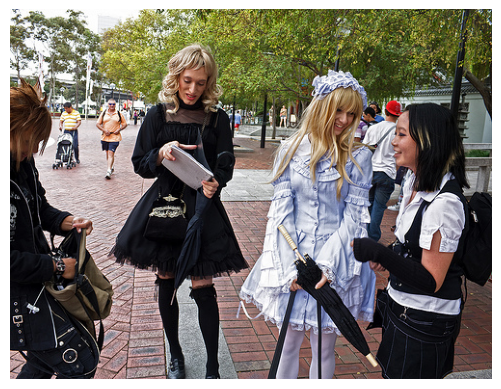


Query: A woman and girl riding downhill on a sled with a dog running alongside them
Top image: 2141713971_e25eb12712.jpg (score: 0.70)


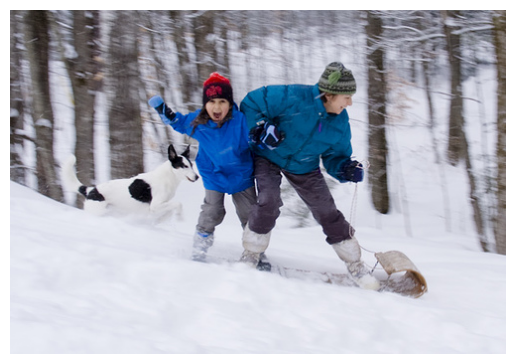


Query: The dog is running .
Top image: 3488087117_2719647989.jpg (score: 0.68)


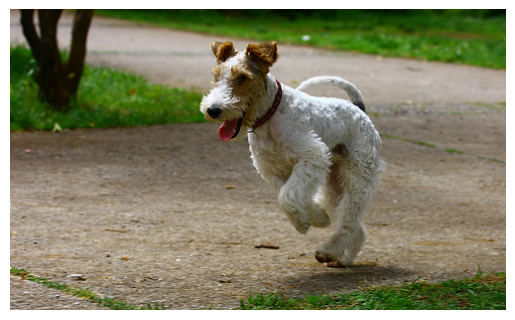


Query: A group of people are ice skating in a big city .
Top image: 269650644_059a84ece5.jpg (score: 0.67)


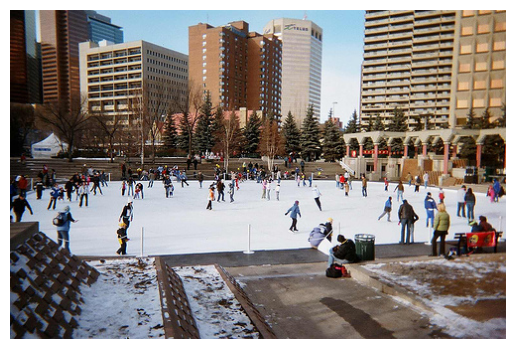


Query: Little kid in blue coat and hat riding a tricycle .
Top image: 2428094795_d3a8f46046.jpg (score: 0.66)


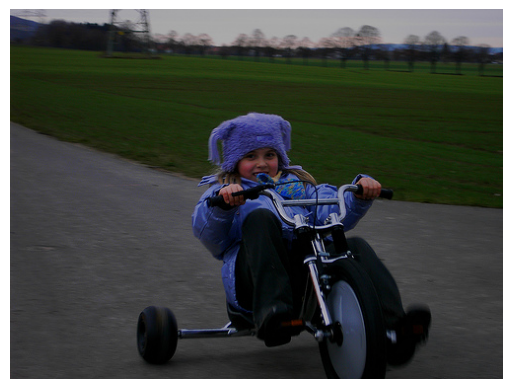


Query: Two black dogs fighting over an orange toy .
Top image: 3553476195_fb3747d7c1.jpg (score: 0.67)


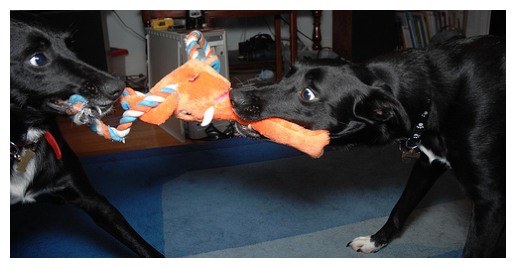


Query: A dog jumping for a tennis ball near an ocean
Top image: 3514297698_0512623955.jpg (score: 0.73)


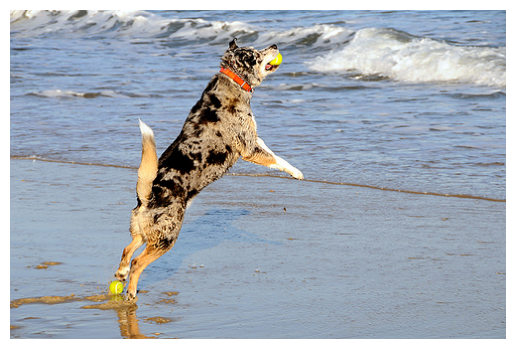


Query: Boy flying a distant kite .
Top image: 2505056124_1276e8dbcb.jpg (score: 0.77)


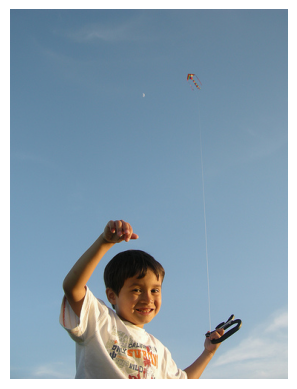


Query: kids play ultimate Frisbee .
Top image: 2121140070_a09644550b.jpg (score: 0.70)


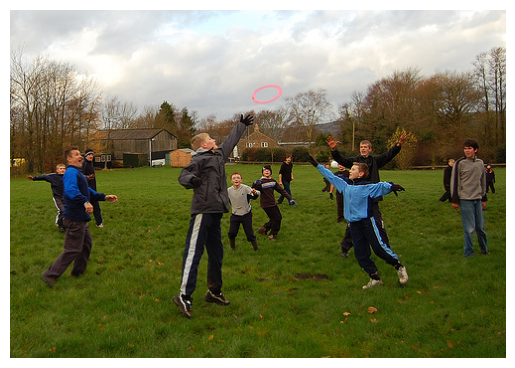


Query: A girl in a purple shirt feeding ducks
Top image: 607339469_af851c4119.jpg (score: 0.66)


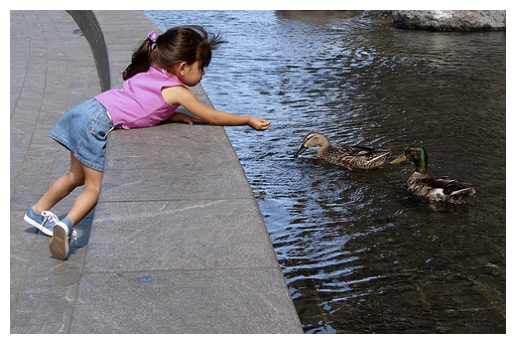

In [92]:
for res in results:
    print(f"\nQuery: {res['query_text']}")
    print(f"Top image: {res['top_image']} (score: {res['score']:.2f})")
    
    try:
        img_path = Path(*test_image_dir, res['top_image'])
        img = Image.open(img_path)
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    except:
        print("Could not display image")

## 8. Выводы

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Проверены экспертные оценки и краудсорсинговые оценки
- [x]  Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- [x]  Изображения векторизованы
- [x]  Текстовые запросы векторизованы
- [x]  Данные корректно разбиты на тренировочную и тестовую выборки
- [x]  Предложена метрика качества работы модели
- [x]  Предложена модель схожести изображений и текстового запроса
- [x]  Модель обучена
- [x]  По итогам обучения модели сделаны выводы
- [x]  Проведено тестирование работы модели
- [x]  По итогам тестирования визуально сравнили качество поиска

**Исследовательский анализ данных:**
- Объединили экспертные и краудсорсинговые оценки с весами 0.6 и 0.4 соответственно
- Удалили записи, где эксперты не пришли к согласию

**Проверка данных:**
- Реализовали эвристический метод для обнаружения запрещённых изображений
- Удалили около 8% изображений, которые потенциально нарушают законодательство

**Векторизация:**
- Для изображений использовали ResNet18 (удалив последний слой)
- Для текстов применили `word2vec` с фиксированным размером вектора

**Модель:**
- Обучили `RandomForestRegressor` для предсказания релевантности
- Достигли `MSE` около 0.01 на тестовой выборке

**Тестирование:**
- Для тестовых запросов модель успешно находит релевантные изображения
- Визуальная проверка подтверждает качество работы модели

**Рекомендации по улучшению:**
- Использовать более современные архитектуры для векторизации (ViT для изображений, BERT для текстов)
- Попробовать нейросетевые подходы для совместного обучения
- Увеличить размер выборки для обучения
- Добавить больше фичей